# A small 1D pic without Poisson
To try out the fake R model

In [1]:
import numpy as np
import scipy as sp
import astropy
from imp import reload

import matplotlib.pyplot as plt
%matplotlib inline

import src

from src.plasma import plasma

from src.functions import generate_maxw, velocity_maxw_flux

reload(src.plasma)
reload(src.functions)

from ipywidgets import IntProgress as prog
from IPython.display import display
%load_ext snakeviz

In [2]:
#parameters
Lx = 1e-2 #System length
dX = 1e-5 #dX in m
Nx = int(Lx/dX)+1 #cell number
Lx = Nx*dX
print("Nx = {Nx}, and Lx = {Lx} cm".format(Nx = Nx, Lx = Lx*100))

Npart = 50*Nx #particles number, in particle par cell
n = 1e17  #[m^-3]
dT = 1e-12 #time step
Te = 20;     #[eV] Electron distribution temperature
Ti = 5 #[eV]

me = 9.109e-31; #[kg] electron mass
q = 1.6021765650e-19; #[C] electron charge
kb = 1.3806488e-23;  #Blozman constant
eps_0 = 8.8548782e-12; #Vaccum permitivitty
mi = 131*1.6726219e27 #[kg]

L_De = np.sqrt(eps_0*Te/(q*n))

dT = 1e-10 #time step

Nx = 1000, and Lx = 1.0 cm


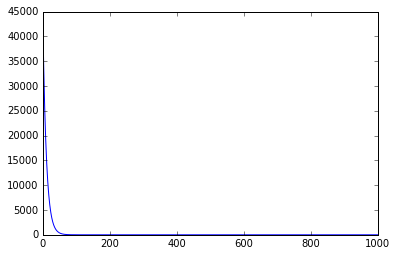

In [3]:
#Generate plasma
pla = plasma(dT,Nx,Lx,Npart,n,Te,Ti)
#fix Electric field profile
pla.E[:,0] = 45e3*np.exp(-pla.x_j/(L_De))
#pla.compute_rho()
plt.plot(pla.E)
plt.show()
#plt.plot(pla.rho)
#plt.show()

 
*** Profile stats marshalled to file '/tmp/tmpbgjgkl67'. 


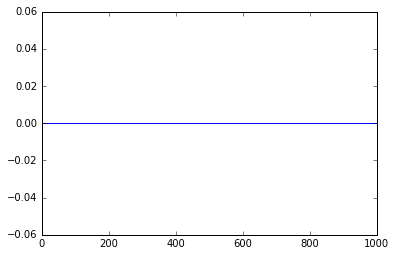

In [4]:
%%snakeviz

#plt.hist(pla.ele.x,label="start",bins=Nx);
Nt = 10
n_av = 100
a = 1.2
plt.plot(pla.ne);

for i in np.arange(Nt):
    pla.pusher()
    pla.boundary()
    
    pla.compute_rho()
    
    
    #We need to had boundary
    if i > 1 and i%n_av ==0:
        ie = pla.history["Ie_w"][-n_av:]
        ii = pla.history["Ii_w"][-n_av:]
        if ie > ii :
            print(i,"times a")
            pla.E[:,0] *= a
        else:
            print(i,"divied by a")
            pla.E[:,0] /= a
    
        plt.plot(pla.ne);


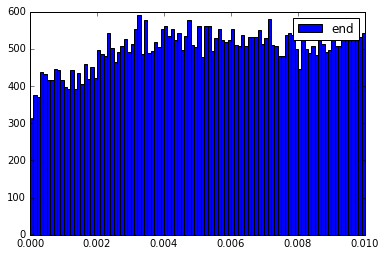

In [6]:
plt.hist(pla.ele.x,label="end",bins=100);
plt.legend()

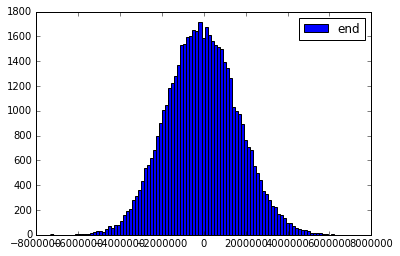

In [7]:
plt.hist(pla.ele.V[:,0],label="end",bins=100);
plt.legend()